# Introduction to scvi-tools
In this introductory tutorial, we go through the different steps of an scvi-tools workflow.

While we focus on scVI in this tutorial, the API is consistent across all models.

In [1]:
import sys

#if branch is stable, will install via pypi, else will install from source
branch = "stable"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@$branch#egg=scvi-tools[tutorials]

     |████████████████████████████████| 72 kB 706 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nbclient 0.5.11 requires jupyter-client>=6.1.5, but you have jupyter-client 5.3.5 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 527 kB 8.1 MB/s 
     |████████████████████████████████| 397 kB 54.6 MB/s 
     |████████████████████████████████| 217 kB 71.2 MB/s 
     |████████████████████████████████| 713 kB 60.8 MB/s 
     |████████████████████████████████| 91 kB 11.7 MB/s 
     |████████████████████████████████| 1.1 MB 54.3 MB/s 
     |████████████████████████████████| 1.4 MB 55.6 MB/s 
     |████████████████████████████████| 2.0 MB 55.2 MB/s 
     |████████████████████████████████| 134 kB 71.1 MB/s 
     |████████████

In [2]:
import scvi
import scanpy as sc
import matplotlib.pyplot as plt

sc.set_figure_params(figsize=(4, 4))

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

Global seed set to 0
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


## Loading and preparing data

Let us first load a subsampled version of the heart cell atlas dataset described in Litviňuková et al. (2020). scvi-tools has many "built-in" datasets as well as support for loading arbitrary `.csv`, `.loom`, and `.h5ad` (AnnData) files. Please see our tutorial on data loading for more examples.

* Litviňuková, M., Talavera-López, C., Maatz, H., Reichart, D., Worth, C. L., Lindberg, E. L., ... & Teichmann, S. A. (2020). Cells of the adult human heart. Nature, 588(7838), 466-472.

<div class="alert alert-info">
Important

All scvi-tools models require AnnData objects as input. 

</div>

In [3]:
adata = scvi.data.heart_cell_atlas_subsampled()

INFO     Downloading file at data/hca_subsampled_20k.h5ad                                    
Downloading...: 100%|██████████| 65714/65714.0 [00:00<00:00, 115577.50it/s]


Now we preprocess the data to remove, for example, genes that are very lowly expressed and other outliers. For these tasks we prefer the [Scanpy preprocessing module](https://scanpy.readthedocs.io/en/stable/api/index.html#module-scanpy.pp).

In [4]:
sc.pp.filter_genes(adata, min_counts=3)

In scRNA-seq analysis, it's popular to normalize the data. These values are not used by scvi-tools, but given their popularity in other tasks as well as for visualization, we store them in the anndata object separately (via the `.raw` attribute).

<div class="alert alert-info">

Important

Unless otherwise specified, scvi-tools models require the raw counts (not log library size normalized).

</div>

In [5]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`

Finally, we perform feature selection, to reduce the number of features (genes in this case) used as input to the scvi-tools model. For best practices of how/when to perform feature selection, please refer to the model-specific tutorial. For scVI, we recommend anywhere from 1,000 to 10,000 HVGs, but it will be context-dependent.

In [6]:
sc.pp.highly_variable_genes(
    adata, 
    n_top_genes=1200, 
    subset=True, 
    layer="counts", 
    flavor="seurat_v3",
    batch_key="cell_source"
)

Now it's time to run `setup_anndata()`, which alerts scvi-tools to the locations of various matrices inside the anndata. It's important to run this function with the correct arguments so scvi-tools is notified that your dataset has batches, annotations, etc. For example, if batches are registered with scvi-tools, the subsequent model will correct for batch effects. See the full documentation for details.

In this dataset, there is a "cell_source" categorical covariate, and within each "cell_source", multiple "donors", "gender" and "age_group". There are also two continuous covariates we'd like to correct for: "percent_mito" and "percent_ribo". These covariates can be registered using the `categorical_covariate_keys` argument. If you only have one categorical covariate, you can also use the `batch_key` argument instead.

In [7]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["cell_source", "donor"],
    continuous_covariate_keys=["percent_mito", "percent_ribo"]
)

<div class="alert alert-warning">

Warning

If the adata is modified after running `setup_anndata`, please run `setup_anndata` again, before creating an instance of a model.

</div>

## Creating and training a model

While we highlight the scVI model here, the API is consistent across all scvi-tools models and is inspired by that of [scikit-learn](https://scikit-learn.org/stable/). For a full list of options, see the scvi [documentation](https://scvi-tools.org).

In [8]:
model = scvi.model.SCVI(adata)

We can see an overview of the model by printing it.

In [9]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Not Trained

<div class="alert alert-info">
Important

All scvi-tools models run faster when using a GPU. By default, scvi-tools will use a GPU if one is found to be available. Please see the installation page for more information about installing scvi-tools when a GPU is available.

</div>

In [10]:
model.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [08:54<00:00,  1.34s/it, loss=284, v_num=1]


### Saving and loading

Saving consists of saving the model neural network weights, as well as parameters used to initialize the model.

In [11]:
# model.save("my_model/")

In [12]:
# model = scvi.model.SCVI.load("my_model/", adata, use_gpu=True)

## Obtaining model outputs

In [13]:
latent = model.get_latent_representation()

It's often useful to store the outputs of scvi-tools back into the original anndata, as it permits interoperability with Scanpy.

In [14]:
adata.obsm["X_scVI"] = latent

The `model.get...()` functions default to using the anndata that was used to initialize the model. It's possible to also query a subset of the anndata, or even use a completely independent anndata object as long as the anndata is organized in an equivalent fashion.

In [15]:
adata_subset = adata[adata.obs.cell_type == "Fibroblast"]
latent_subset = model.get_latent_representation(adata_subset)

INFO     Received view of anndata, making copy.                                              
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


In [16]:
denoised = model.get_normalized_expression(adata_subset, library_size=1e4)
denoised.iloc[:5, :5]

INFO     Received view of anndata, making copy.                                              
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


,ISG15,TNFRSF18,VWA1,HES5,SPSB1
GTCAAGTCATGCCACG-1-HCAHeart7702879,0.489661,0.201276,2.470901,0.016657,4.387682
GAGTCATTCTCCGTGT-1-HCAHeart8287128,1.628487,0.201958,2.162455,0.028410,17.678003
CCTCTGATCGTGACAT-1-HCAHeart7702881,6.141402,0.399761,1.379086,0.215456,3.254043
CGCCATTCATCATCTT-1-H0035_apex,0.266829,0.029151,0.572562,0.151238,5.672157
TCGTAGAGTAGGACTG-1-H0015_septum,0.251636,0.014270,0.383613,0.502105,8.979503


Let's store the normalized values back in the anndata.

In [17]:
adata.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size=10e4
)

## Interoperability with Scanpy

Scanpy is a powerful python library for visualization and downstream analysis of scRNA-seq data. We show here how to feed the objects produced by scvi-tools into a scanpy workflow.

### Visualization without batch correction

<div class="alert alert-warning">

Warning

We use UMAP to *qualitatively* assess our low-dimension embeddings of cells. We do not advise using UMAP or any similar approach quantitatively. We do recommend using the embeddings produced by scVI as a plug-in replacement of what you would get from PCA, as we show below.

</div>

First, we demonstrate the presence of nuisance variation with respect to nuclei/whole cell, age group, and donor by plotting the UMAP results of the top 30 PCA components for the raw count data.

In [19]:
# run PCA then generate UMAP plots
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)

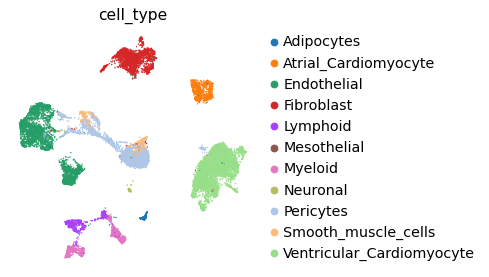

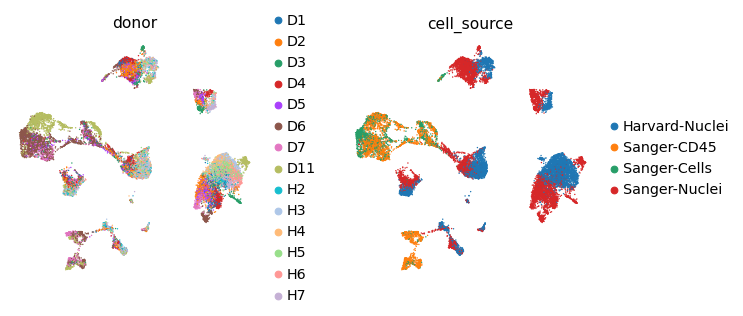

In [20]:
sc.pl.umap(
    adata, 
    color=["cell_type"], 
    frameon=False,
)
sc.pl.umap(
    adata, 
    color=["donor", "cell_source"],
    ncols=2,
    frameon=False,
)

We see that while the cell types are generally well separated, nuisance variation plays a large part in the variation of the data.

### Visualization with batch correction (scVI)

Now, let us try using the scVI latent space to generate the same UMAP plots to see if scVI successfully accounts for batch effects in the data.

In [21]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)

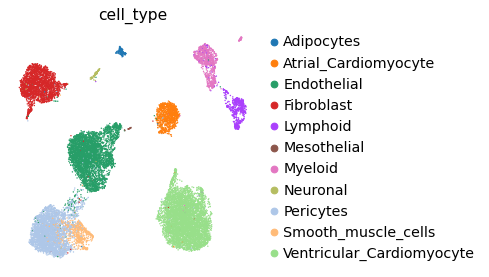

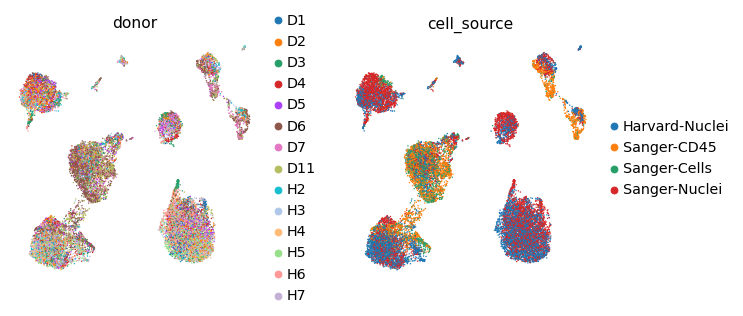

In [22]:
sc.pl.umap(
    adata, 
    color=["cell_type"], 
    frameon=False,
)
sc.pl.umap(
    adata, 
    color=["donor", "cell_source"],
    ncols=2,
    frameon=False,
)

We can see that scVI was able to correct for nuisance variation due to nuclei/whole cell, age group, and donor, while maintaining separation of cell types.

### Clustering on the scVI latent space

The user will note that we imported curated labels from the original publication. Our interface with scanpy makes it easy to cluster the data with scanpy from scVI's latent space and then reinject them into scVI (e.g., for differential expression).

In [23]:
# neighbors were already computed using scVI
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.5)

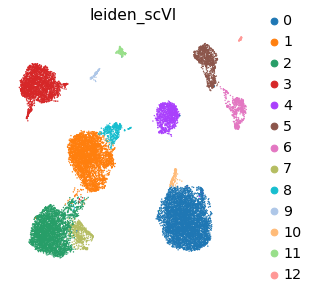

In [24]:
sc.pl.umap(
    adata, 
    color=["leiden_scVI"], 
    frameon=False,
)

## Differential expression
We can also use many scvi-tools models for differential expression. For further details on the methods underlying these functions as well as additional options, please see the [API docs](https://docs.scvi-tools.org/en/stable/api/reference/scvi.model.SCVI.differential_expression.html#scvi.model.SCVI.differential_expression).

In [25]:
adata.obs.cell_type.head()

AACTCCCCACGAGAGT-1-HCAHeart7844001                      Myeloid
ATAACGCAGAGCTGGT-1-HCAHeart7829979    Ventricular_Cardiomyocyte
GTCAAGTCATGCCACG-1-HCAHeart7702879                   Fibroblast
GGTGATTCAAATGAGT-1-HCAHeart8102858                  Endothelial
AGAGAATTCTTAGCAG-1-HCAHeart8102863                  Endothelial
Name: cell_type, dtype: category
Categories (11, object): ['Adipocytes', 'Atrial_Cardiomyocyte', 'Endothelial', 'Fibroblast', ...,
                          'Neuronal', 'Pericytes', 'Smooth_muscle_cells',
                          'Ventricular_Cardiomyocyte']

For example, a 1-vs-1 DE test is as simple as:

In [26]:
de_df = model.differential_expression(
    groupby="cell_type", 
    group1="Endothelial", 
    group2="Fibroblast"
)
de_df.head()

DE...: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
SLC9A3R2,0.9994,0.0006,7.417964,0.010747,0.000173,0.0,0.25,5.970417,6.036353,1.670780,-6.060678,12.085898,4.451492,0.045380,0.712339,0.034342,111.582703,1.657324,True,Endothelial vs Fibroblast,Endothelial,Fibroblast
SOX17,0.9990,0.0010,6.906745,0.001591,0.000031,0.0,0.25,6.268049,6.267763,2.115778,-2.416451,13.845300,0.784371,0.006541,0.307617,0.004497,17.128170,0.185868,True,Endothelial vs Fibroblast,Endothelial,Fibroblast
ABCA10,0.9990,0.0010,6.906745,0.000084,0.006385,0.0,0.25,-8.055528,-8.546453,2.726494,-16.670414,2.988153,0.014359,1.282508,0.007788,0.499591,0.501825,69.613876,True,Endothelial vs Fibroblast,Endothelial,Fibroblast
CDH19,0.9988,0.0012,6.724225,0.000291,0.013203,0.0,0.25,-7.320049,-7.425292,2.611001,-16.807497,1.904790,0.049890,3.217938,0.014359,0.672527,1.843119,137.330276,True,Endothelial vs Fibroblast,Endothelial,Fibroblast
EGFL7,0.9986,0.0014,6.569875,0.008701,0.000383,0.0,0.25,4.844395,4.838248,1.565036,-8.348671,11.315140,2.376779,0.036795,0.741543,0.025756,89.507553,1.169474,True,Endothelial vs Fibroblast,Endothelial,Fibroblast


We can also do a 1-vs-all DE test, which compares each cell type with the rest of the dataset:

In [27]:
de_df = model.differential_expression(
    groupby="cell_type", 
)
de_df.head()

DE...: 100%|██████████| 11/11 [00:07<00:00,  1.48it/s]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
PLIN1,0.9982,0.0018,6.318161,0.004967,0.000052,0.0,0.25,7.962127,7.755765,3.024813,-4.720932,18.925732,2.799999,0.004379,0.806897,0.004325,52.921761,0.196486,True,Adipocytes vs Rest,Adipocytes,Rest
GPAM,0.9982,0.0018,6.318161,0.025644,0.000208,0.0,0.25,7.335163,7.379781,2.560578,-2.490395,18.955227,17.372416,0.035791,0.896552,0.031520,280.340485,1.565905,True,Adipocytes vs Rest,Adipocytes,Rest
GPD1,0.9980,0.0020,6.212601,0.002255,0.000043,0.0,0.25,6.652276,6.209249,2.840967,-1.215029,16.538391,1.758620,0.007353,0.620690,0.007299,30.203791,0.255079,True,Adipocytes vs Rest,Adipocytes,Rest
ADIPOQ,0.9978,0.0022,6.117091,0.003532,0.000049,0.0,0.25,7.885108,7.593197,3.439714,-5.901521,20.419264,2.324136,0.003622,0.593103,0.003352,33.361748,0.217763,True,Adipocytes vs Rest,Adipocytes,Rest
PNPLA3,0.9974,0.0026,5.949637,0.003658,0.000033,0.0,0.25,7.716955,7.607253,3.174452,-3.076790,20.980171,2.020689,0.002811,0.537931,0.002757,28.458160,0.127947,True,Adipocytes vs Rest,Adipocytes,Rest


We now extract top markers for each cluster using the DE results.

In [28]:
markers = {}
cats = adata.obs.cell_type.cat.categories
for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_mean > 0]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 3]
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]

    markers[c] = cell_type_df.index.tolist()[:3]

In [29]:
sc.tl.dendrogram(adata, groupby="cell_type", use_rep="X_scVI")

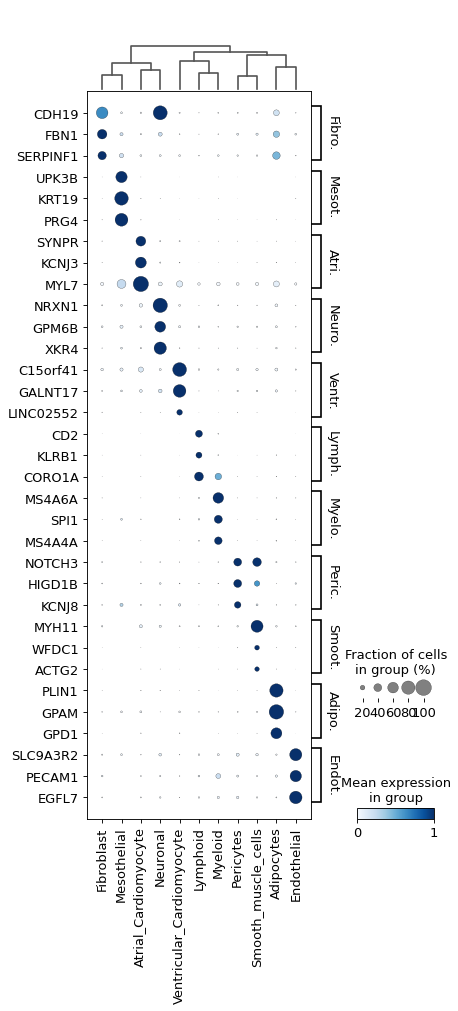

In [30]:
sc.pl.dotplot(
    adata, 
    markers, 
    groupby='cell_type', 
    dendrogram=True, 
    color_map="Blues",
    swap_axes=True,
    use_raw=True,
    standard_scale="var",
)

We can also visualize the scVI normalized gene expression values with the `layer` option.

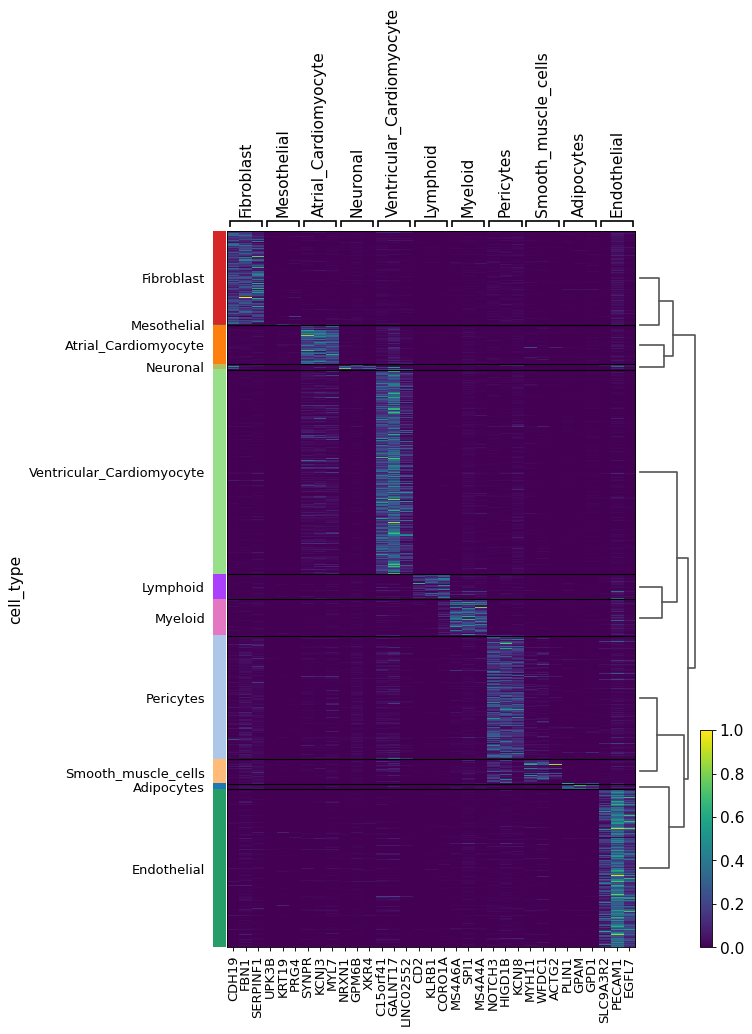

In [31]:
sc.pl.heatmap(
    adata, 
    markers, 
    groupby='cell_type', 
    layer="scvi_normalized",
    standard_scale="var",
    dendrogram=True,
    figsize=(8, 12)
)

## Logging information

Verbosity varies in the following way:

* `logger.setLevel(logging.WARNING)` will show a progress bar.
* `logger.setLevel(logging.INFO)` will show global logs including the number of jobs done.
* `logger.setLevel(logging.DEBUG)` will show detailed logs for each training (e.g the parameters tested).

This function's behaviour can be customized, please refer to its documentation for information about the different parameters available.

In general, you can use `scvi.settings.verbosity` to set the verbosity of the scvi package.
Note that `verbosity` corresponds to the logging levels of the standard python `logging` module. By default, that verbosity level is set to `INFO` (=20).
As a reminder the logging levels are:

<table class="docutils align-center">
<colgroup>
<col style="width: 48%">
<col style="width: 52%">
</colgroup>
<thead>
<tr class="row-odd"><th class="head"><p>Level</p></th>
<th class="head"><p>Numeric value</p></th>
</tr>
</thead>
<tbody>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">CRITICAL</span></code></p></td>
<td><p>50</p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">ERROR</span></code></p></td>
<td><p>40</p></td>
</tr>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">WARNING</span></code></p></td>
<td><p>30</p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">INFO</span></code></p></td>
<td><p>20</p></td>
</tr>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">DEBUG</span></code></p></td>
<td><p>10</p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">NOTSET</span></code></p></td>
<td><p>0</p></td>
</tr>
</tbody>
</table>